Two tricks to improve perfomance of Network:
    - Experience Replay
    - Freezing Target Networks
    
Great post on theory behind Q-Learning: http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/

# Q-Table Learning

In [2]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
%matplotlib inline

[2017-02-24 23:00:08,781] Making new env: FrozenLake-v0


In [5]:
env = gym.make('FrozenLake-v0')

q_table = np.zeros((env.observation_space.n, env.action_space.n))
env.action_space.n, env.observation_space.n

learning_rate = 0.85
discount_factor = 0.99

NUM_EPISODES = 2000
MAX_T = 99
DEBUG = False

reward_list = []


def select_action(env, state, episode):
    # Стохастическая среда
    action = np.argmax(q_table[state] + np.random.randn(1, \
                                        env.action_space.n)*(1/(episode+1)))
    return action


for episode in range(NUM_EPISODES):
    state_0 = env.reset()
    reward_all = 0
    t = 0
    while t < MAX_T:
        t += 1

        action = select_action(env, state_0, episode)
        state, reward, done, _ = env.step(action)
        
        best_q = np.max(q_table[state])
        q_table[state_0, action] += learning_rate * (reward + discount_factor*best_q\
                                                      - q_table[state_0, action])
        reward_all += reward
        state_0 = state
        
        if done:
            if DEBUG:
                print("Episode {} finished after {} timesteps".format(episode, t))
            break
            
    reward_list.append(reward_all)

print("Average score: {}".format(sum(reward_list)/NUM_EPISODES))
env.close()

Average score: 0.521


# Q-Learning with NN

In [6]:
import tensorflow as tf

In [67]:
tf.reset_default_graph()
inputs1 = tf.placeholder(shape=[1,16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4], 0, 0.01))
q_out = tf.matmul(inputs1, W)
predict = tf.argmax(q_out, 1)

next_q = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(next_q - q_out))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
update_model = trainer.minimize(loss)

env = gym.make('FrozenLake-v0')

init = tf.initialize_all_variables()

discount_factor = 0.99
exploration_rate = 0.1
NUM_EPISODES = 2000
MAX_T = 99
DEBUG = False

step_list = []
reward_list = []
with tf.Session() as sess:
    sess.run(init)
    for episode in range(NUM_EPISODES):
        state_0 = env.reset()
        reward_all = 0
        t = 0
        while t < MAX_T:
            t += 1
            action, target_q = sess.run([predict, q_out], feed_dict\
                                     ={inputs1:np.identity(16)[state_0:state_0+1]})
            if np.random.rand(1) < exploration_rate:
                action[0] = env.action_space.sample()
            
            state, reward, done, _ = env.step(action[0])
            
            q1 = sess.run(q_out, feed_dict={inputs1:np.identity(16)[state:state+1]})
            max_q1 = np.max(q1)
            
            target_q[0, action[0]] = reward + discount_factor * max_q1
            
            _, W1 = sess.run([update_model, W], feed_dict={inputs1:np.identity(16)[state_0\
                                                           :state_0+1], next_q:target_q})
            reward_all += reward
            state_0 = state
            
            if done:
                if DEBUG:
                    print("Episode {} finished after {} timesteps".format(episode, t))
                break
                
        step_list.append(t)
        reward_list.append(reward_all)
        
print("Average score: {}".format(sum(reward_list)/NUM_EPISODES))
env.close()

[2017-02-24 23:53:54,347] Making new env: FrozenLake-v0


Average score: 0.34


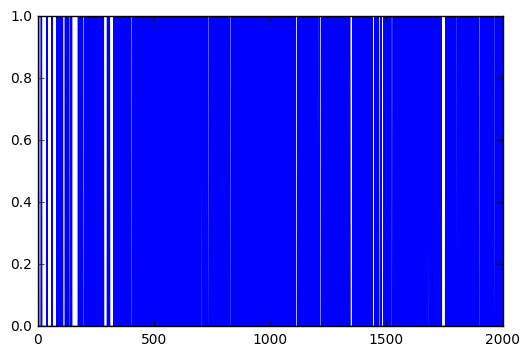

In [68]:
plt.plot(reward_list)

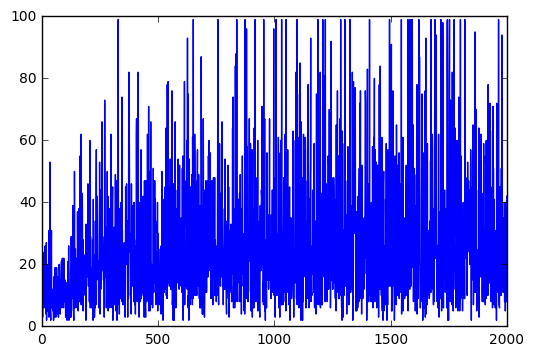

In [69]:
plt.plot(step_list)